# Obtención Pixel Metro

### Imports

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import argparse

### Obtener una imagen de mesa recortada

In [ ]:
b,g,r = cv2.split(cv2.imread("segmentation_masks/36.png"))
img = r
img = cv2.resize(img,(320,180))
thresh = cv2.threshold(img,128,255,cv2.THRESH_BINARY)[1]
contours,hierarchy = cv2.findContours(thresh, 1, 2)
for a in range(len(contours)):
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    if w<=5 or h<=5:
        continue
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),1)

In [ ]:
im = Image.open(r"./images/10000036.jpg")

In [ ]:
croped = im.crop((x*6, y*6, x*6+w*6 , y*6+h*6))

In [ ]:
croped.save("./table", "jpeg")

### Implementación

In [172]:
def kmeansImg(image,clusters = 60):
    image_copy = np.copy(image)
    pixel_values = image_copy.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    number_of_attempts = 5
    centroid_initialization_strategy = cv2.KMEANS_RANDOM_CENTERS
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    _, labels, centers = cv2.kmeans(pixel_values,clusters,None,stop_criteria,number_of_attempts,centroid_initialization_strategy)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]

    segmented_image = segmented_data.reshape(image_copy.shape)
    
    return segmented_image

In [173]:
def getLines(img):
    img = cv2.resize(img,(400,80))
    kmeans = kmeansImg(img)
    gray = cv2.cvtColor(kmeans,cv2.COLOR_BGR2GRAY)

    kernel_size = 1
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    low_threshold = 50
    high_threshold = 125
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    kernel = np.ones((6,6),np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40  # minimum number of pixels making up a line
    max_line_gap = 40  # maximum gap in pixels between connectable line segments
    line_image = np.copy(img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(closing, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    
    return lines

In [228]:
img = cv2.imread("./taula5.JPG")
img = cv2.resize(img,(400,80))
kmeans = kmeansImg(img)
gray = cv2.cvtColor(kmeans,cv2.COLOR_BGR2GRAY)

kernel_size = 1
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
#ret,blur_gray = cv2.threshold(gray,120,255,cv2.THRESH_BINARY)

In [229]:
#blur_gray = imagen - gray
low_threshold = 50
high_threshold = 125
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
kernel = np.ones((6,6),np.uint8)
#felz = felzenszwalb(edges, scale = 1000, sigma = 0.5, min_size = 500)
#edges = cv2.Canny(np.uint8(((felz/felz.max())*255)), low_threshold, high_threshold)
#closing = cv2.dilate(edges, kernel)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

In [230]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(closing, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),5)

In [231]:
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

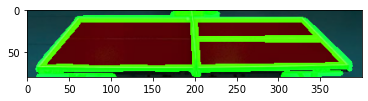

In [239]:
plt.imshow(lines_edges)

In [179]:
#felz = felzenszwalb(img, scale = 1000, sigma = 0.5, min_size = 500)
#e = cv2.Canny(np.uint8(((felz/felz.max())*255)), low_threshold, high_threshold)
#plt.imshow(np.uint8(((felz/felz.max())*255)))

In [240]:
cv2.imwrite("./tables/lined2.jpg",lines_edges)

True

In [181]:
def getMaxLine(lines, lim = False):
    """
    Encuentra la linea más larga que será la de 2.74 m de la mesa
    """
    maxline = 0
    maxvalues = []
    m = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y1 <= 10 or y2 <= 10) and lim == True:
                continue
            dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if dist>maxline:
                maxline = dist
                maxvalues = [x1,y1,x2,y2]
    return maxvalues


def eraseDuplicates(lines, l, acc = 10):
    """
    Elimina las lineas repetidas
    """
    new_lines = []
    xl1,yl1,xl2,yl2 = l
    xm1,ym1,xm2,ym2 = l
    count = 1
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc):
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc):
                    xm1 += x1
                    ym1 += y1
                    xm2 += x2
                    ym2 += y2
                    count +=1
                    continue
            new_lines.append(line)
    return (np.array(new_lines),[int(xm1/count),int(ym1/count),int(xm2/count),int(ym2/count)])

                    
def getBestCorner(lines, l, right, acc = 10):
    """
    Encuentra las lineas paralelas a la dada sin devolver repeticiones
    """
    lines,_ = eraseDuplicates(lines, l)
    xl1,yl1,xl2,yl2 = l
    ml = (yl2 - yl1)/(xl2 - xl1)
    
    best_line = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if right == True:
                if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc) and (y1 > y2):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha>25 and alpha<90) or (alpha < -40 and alpha > -90):
                        best_line.append([[x1,y1,x2,y2]])
            else:
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc) and (y1 < y2):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha<-20 and alpha>-90) or (alpha > 40 and alpha < 90):
                        best_line.append([[x1,y1,x2,y2]])
                    
    if best_line == []: #No ha encontrado linea buena
        if acc == 500:
            return [0,0,0,0]
        return getBestCorner(lines, l, right, acc+1)
    else:
        return getMaxLine(np.array(best_line))
    
def getRectangle(img, lines, show = False):
    """
    Crea el rectangulo a partir de las lineas sacadas de la imagen
    """
    xa1,ya1,xb1,yb1 = getMaxLine(lines, lim = True)
    xa2,ya2,xc1,yc1 = getBestCorner(lines,getMaxLine(lines),True)
    xd1,yd1,xb2,yb2 = getBestCorner(lines,getMaxLine(lines),False)
    y,x,_ = img.shape
    xa = int(((xa1 + xa2) / 2)*x/400)
    ya = int(((ya1 + ya2) / 2)*y/80)
    xb = int(((xb1 + xb2) / 2)*x/400)
    yb = int(((yb1 + yb2) / 2)*y/80)
    xc = int(xc1*x/400)
    yc = int(yc1*y/80)
    xd = int(xd1*x/400)
    yd = int(yd1*y/80)
    if show == True:
        cv2.line(img,(xa,ya),(xb,yb),(0,255,0),5);
        cv2.line(img,(xa,ya),(xc,yc),(0,255,0),5);
        cv2.line(img,(xd,yd),(xb,yb),(0,255,0),5);
        cv2.line(img,(xc,yc),(xd,yd),(0,255,0),5);
        plt.imshow(img)
    return ([xa,ya],[xb,yb],[xc,yc],[xd,yd])

In [182]:
#new_lines = []
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        new_lines.append([[x2,y2,x1,y1]])

#lines = np.append(lines,np.array(new_lines), axis=0)

#a,b,c,d = getRectangle(img,lines,True)

In [183]:
def check_table(t):
    [[xa,ya],[xb,yb],[xc,yc],[xd,yd]] = t
    bottom = math.sqrt((xa-xb)**2+(ya-yb)**2)
    top = math.sqrt((xc-xd)**2+(yc-yd)**2)
    left = math.sqrt((xa-xc)**2+(ya-yc)**2)
    right = math.sqrt((xb-xd)**2+(yb-yd)**2)
    if top<80 or bottom<150 or right<10 or left<10:
        return False
    elif 0.3>(top/bottom) or 2<(top/bottom):
        return False
    elif 0.3>(left/right) or 3<(left/right):
        return False
    return True

In [257]:
def get_Table(imagen, show = False):
    tabs = []
    for tab in range(10):
        img = np.copy(imagen)
        lines = getLines(img)
        new_lines = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                new_lines.append([[x2,y2,x1,y1]])
        lines = np.append(lines,np.array(new_lines), axis=0)
        a,b,c,d = getRectangle(img,lines)
        tabs += [[a,b,c,d]]
    
    num = np.zeros(len(tabs))
    count = 0
    for ind,t in enumerate(tabs):
        a,b,c,d = t
        trapez = np.copy(img) * 0
        ppt = np.array([a,c,d,b], np.int32)
        ppt = ppt.reshape((-1, 1, 2))
        trapA = cv2.cvtColor(cv2.fillPoly(trapez, [ppt], (255), 8),cv2.COLOR_BGR2GRAY)
        for x in tabs:
            a,b,c,d = x
            trapez = np.copy(img) * 0
            ppt = np.array([a,c,d,b], np.int32)
            ppt = ppt.reshape((-1, 1, 2))
            trapB = cv2.cvtColor(cv2.fillPoly(trapez, [ppt], (255), 8),cv2.COLOR_BGR2GRAY)
            totalA = cv2.countNonZero(cv2.bitwise_or(trapA,trapB))
            totalB = cv2.countNonZero(cv2.bitwise_and(trapA,trapB))
            if (totalB/totalA) > 0.9:
                count += 1
                num[ind] = count
        count = 0
    
    table = tabs[num.argmax()]
    
    if check_table(table) == False:
        [[xa,ya],[xb,yb],_,_] = table
        if math.sqrt((xa-xb)**2+(ya-yb)**2) < 250:
            [[xa,ya],[xb,yb]] = [[0,75],[400,76]]
        m1 = (yb - ya)/(xb - xa)
        T1 = math.tan(110*np.pi/180)
        T2 = math.tan(70*np.pi/180)
        md = (m1-T1)/(1+m1*T1)
        nd = yb - (xb * md)
        yd = 0
        xd = int((yd-nd)/md)
        mc = (m1-T2)/(1+m1*T2)
        nc = ya - (xa * mc)
        yc = 0
        xc = int((yc-nc)/mc)
        if ya>=yb:
            n1 = yd - (xd * m1)
            (xc,yc) = getPointSec([xa,ya,xc,yc],[0,n1,xd,yd])
            xc = int(xc)
            yc = int(yc)
        else:
            n1 = yc - (xc * m1)
            (xd,yd) = getPointSec([xb,yb,xd,yd],[0,n1,xc,yc])
            xd = int(xd)
            yd = int(yd)
    else:   
        [[xa,ya],[xb,yb],[xc,yc],[xd,yd]] = table
        
    if show == True:
        cv2.line(img,(xa,ya),(xb,yb),(0,255,0),5);
        cv2.line(img,(xa,ya),(xc,yc),(0,255,0),5);
        cv2.line(img,(xd,yd),(xb,yb),(0,255,0),5);
        cv2.line(img,(xc,yc),(xd,yd),(0,255,0),5);
        plt.imshow(img)
    return table

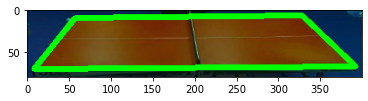

In [223]:
a,b,c,d = get_Table(img,True)

In [186]:
#cv2.imwrite("./tables/problema_reflejo.jpg",img)

In [187]:
# a b = 2.74
# c d = 2.74
# a c = 1.525
# b d = 1.525

In [188]:
l1 = a+b
l2 = c+d
l3 = a+c
l4 = b+d

In [189]:
def scalePoints(x,y,a,b,c,d):
    """
    Obtiene los puntos de la esquina de la mesa, y los convierte en lineas
    escaladas a la medida de la imagen
    """
    a[0]+=x
    b[0]+=x
    c[0]+=x
    d[0]+=x
    a[1]+=y
    b[1]+=y
    c[1]+=y
    d[1]+=y
    l1 = a+b
    l2 = c+d
    l3 = a+c
    l4 = b+d
    return (l1,l2,l3,l4)

In [190]:
# Sumar a las rectas las coordenadas x0 y y0 

In [191]:
def getDist(pt,l):
    """
    Devuleve la distáncia entre un punto y una linea
    """
    x1,y1,x2,y2 = l
    px,py = pt
    m = (y2 - y1)/(x2 - x1)
    n = y1 - (x1 * m)
    dist = ((-m*px) + py - n) / math.sqrt(m**2 + 1)
    return abs(dist)

def getPixelMeterX(pt,l1,l2, horitzontal = True):
    """
    Devuelve la relación píxel metro de un punto en el eje "X"
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    dl1 = math.sqrt((x1-x2)**2+(y1-y2)**2)
    dl2 = math.sqrt((a1-a2)**2+(b1-b2)**2)
    d1_2 = getDist((a1,b1),l1)
    d1_p = getDist(pt,l1)
    if horitzontal == True:
        rel = 2.74
    else:
        rel = 1.525
    pm = (dl1 - ((dl1-dl2)/d1_2)*d1_p) / rel
    return pm

def getPointSec(l1,l2):
    """
    Devuelve el punto de corte entre dos rectas, si estas son paralelas
    se asume punto en el centro y a una distancia "infinita"
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    m1 = (y2 - y1)/(x2 - x1)
    m2 = (b2 - b1)/(a2 - a1)
    n1 = y1 - (x1 * m1)
    n2 = b1 - (a1 * m2)
    if m1 == m2:
        return ((((1-n1)/m1)+((1-n2)/m2))/2,999999999)
    px = (n2 - n1) / (m1 - m2)
    py = m1*px + n1
    return (px,py)

def getRectaPerp(pt,l):
    """
    Devuelve la recta perpendicular a otra que pasa por un punto
    """
    x1,y1,x2,y2 = l
    px,py = pt
    ml = (y2 - y1)/(x2 - x1)
    try:
        m = 1 / ml
    except:
        m = 9999999999999999999
    n = py - (px * m)
    lperp = [px,py,px+50,(m*(px+50))+n]
    return lperp

def getAngleRect(l1,l2):
    """
    Devuelve el angulo formado por dos rectas
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    m1 = (y2 - y1)/(x2 - x1)
    m2 = (b2 - b1)/(a2 - a1)
    alpha = math.atan((m1 - m2)/(1+m1*m2))* 180 / np.pi
    return abs(alpha)

def getPixelMeterY(pt, l1, l2, l3, l4, horitzontal = False, paralel = True):
    """
    Devuelve la relación píxel metro de un punto en el eje "Y" y el punto focal
    pt: punto de movimiento
    l1: recta horizontal de mesa
    l2: recta horizontal superior mesa
    l3: recta lateral de mesa
    l4: recta otro lateral de mesa
    """
    pa,pb = getPointSec(l3,l4)
    px,py = pt
    lp = [px,py,pa,pb]
    beta = getAngleRect(l3,lp)
    
    if paralel == True:
        lperp = getRectaPerp((pa,pb),l1)
        alpha = getAngleRect(l3,lperp)
        dist = getDist((l2[0],l2[1]),l1)
    else:
        alpha = getAngleRect(l3,l4)
        dist = math.sqrt((l4[0]-l4[2])**2+(l4[1]+l4[3])**2)
    
    x1,y1,x2,y2 = l3
    length = math.sqrt((x1-x2)**2+(y1-y2)**2)
    
    if horitzontal == True:
        rel = 2.74
    else:
        rel = 1.525
    
    pm = ((((beta+alpha)/alpha)*(length-dist))+dist) / rel
    return (pm, (pa,pb))


def getMeters(p1,p2,l1,l2,l3,l4):
    """
    Devuelve los metros recorridos en nuevo x y nuevo y
    p1: punto de partida
    p2: punto final
    l1: recta horizontal de mesa
    l2: recta horizontal superior mesa
    l3: recta lateral de mesa
    l4: recta otro lateral de mesa
    """
    if p1 == p2:
        return 0
    
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    m1 = (y2 - y1)/(x2 - x1)
    m2 = (b2 - b1)/(a2 - a1)
    
    paralel = True
    if abs(m1-m2) > 0.15 :
        print("?")
        paralel = False
    
    if paralel == True:
        pmx = getPixelMeterX(p1,l1,l2)
        pmy,pf = getPixelMeterY(p2,l1,l2,l3,l4)
        print(pmy)
    else:
        pmx,pfx = getPixelMeterY(p1,l3,l4,l1,l2,horitzontal=True,paralel=False)
        pmy,pf = getPixelMeterY(p2,l1,l2,l3,l4,paralel=False)
    
    #x1,y1,x2,y2 = l1
    #m = (y2 - y1)/(x2 - x1)
    p1x,p1y = p1
    n = p1y - (p1x * m1)
    
    if paralel == True:
        lp1 = [p1x,p1y,p1x+50,(m1*(p1x+50))+n]
    else:
        lp1 = [pfx[0],pfx[1],p1x,p1y]
    
    p2x,p2y = p2
    # lp2 = [p2x,p2y,p2x+50,(m*(p2x+50))+n]
    
    p3 = getPointSec(lp1,[pf[0],pf[1],p2x,p2y])
    # p4 = getPointSec(lp2,[pf[0],pf[1],p1x,p1y])
    # De p1 a p3 dist. horizontal = De p4 a p2 dist. horizontal
    # De p1 a p4 dist. vertical = De p3 a p2 dist. vertical
    
    p3x,p3y = p3
    distX = math.sqrt((p1x-p3x)**2+(p1y-p3y)**2) # En píxeles
    distY = math.sqrt((p3x-p2x)**2+(p3y-p2y)**2)
    
    distMX = distX / pmx
    distMY = distY / pmy
    
    moved = math.sqrt(distMX**2 + distMY**2)
    
    return moved

In [192]:
getDist((2,-1),[1,-0.75,3,-2.25])

0.4

In [193]:
getAngleRect([0,1,2,-1],[1,0,2,3])

63.43494882292201

In [194]:
getPointSec([0,1,1,2],[0,2,1,3])

(-0.5, 999999999)

94.83129199526266


0.014898686848890917

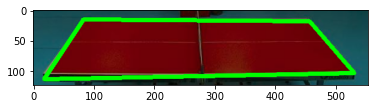

In [258]:
img = cv2.imread("./taula5.JPG")
#lines = getLines(img)
a,b,c,d = get_Table(img,True)
# Obtener escala x y y
x = 350
y = 400
l1,l2,l3,l4 = scalePoints(x,y,a,b,c,d)
# Obtener punto origne y punto destino
p1 = (100, 300)
p2 = (101, 300)
getMeters(p1,p2,l1,l2,l3,l4)

In [251]:
getMeters((1000+412.5,450),(1000+137.5,350),[500,500,1000,501],[550,300,950,301],[500,500,550,300],[1000,501,950,301])

146.00525250133893


1.523823742253522